In [1]:
from data import *
from encoders import *
from config import *
from models import *
from evals import *
print("using device: ", device)

import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# import importlib
# import models
# importlib.reload(models)


using device:  cpu


/Users/joyqiu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# ugly engineering here
df = pd.read_csv('../../data/HR_events.csv')
df_y = pd.read_excel('../../data/PAS Challenge Outcome Data.xlsx', engine="calamine")
df_y = df_y[['VitalID', 'Died']]
df = df.merge(df_y, on='VitalID', how='left')
df['label'] = df.index.to_series()
df['text'] = df['Died'].apply(lambda x: 'This infant will die in 7 days. ' if x == 1 else 'This infant will survive. ')
# df['text'] = df['text'] +' '+ df['event_description'].astype(str)


df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['text'])    
df_train['text'] = df_train['text'] +' '+ df_train['event_description'].astype(str)
df_test['text'] = df_test['text'] +' '+ df_test['event_description'].astype(str)


In [3]:
df_new = df_train
df_new['outcome'] = df_new['Died'].apply(lambda x: 'class1' if x == 1 else 'class2')
df_new_y = pd.get_dummies(df_new['outcome'])
y_true_train = torch.tensor(df_new_y.values)
ts_df_train = df_new.loc[:,'1':'300']


df_new = df_test
df_new['outcome'] = df_new['Died'].apply(lambda x: 'class1' if x == 1 else 'class2')
df_new_y = pd.get_dummies(df_new['outcome'])
y_true_test = torch.tensor(df_new_y.values)
ts_df_test = df_new.loc[:,'1':'300']

txt_ls = ['die in 7 days', 'survive']

In [4]:
# text_encoder_name = 'dmis-lab/biobert-base-cased-v1.2'
text_encoder_name = 'sentence-transformers/all-mpnet-base-v2'
ts_encoder_name = 'hr_vae_linear_medium'
ts_f_train, tx_f_train, labels_train = get_features(df_train,ts_encoder_name,text_encoder_name)
train_dataloader = CLIPDataset(ts_f_train, tx_f_train, labels_train).dataloader(batch_size=128)

ts_f_test, tx_f_test, labels_test = get_features(df_test, ts_encoder_name,text_encoder_name)
test_dataloader = CLIPDataset(ts_f_test, tx_f_test, labels_test).dataloader(batch_size=128)


/Users/joyqiu/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [6]:
overwrite = False
model_path = './results/clip_hr_death_binary_by_similarity.pth' 
loss_path = './results/clip_hr_death_binary_by_similarity_losses.pth'
eval_metrics_path = './results/clip_hr_death_binary_by_similarity_eval_metrics.pth'
# Initialize model
model = CLIPModel(
        ts_dim=ts_f_train.shape[1],    # 32
        text_dim=tx_f_train.shape[1],  # 768
        projection_dim=128
    )
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # Reduce LR when metric stops decreasing
    factor=0.9,          # Multiply LR by this factor
    patience=50,          # Number of epochs to wait before reducing LR
    min_lr=1e-10         # Don't reduce LR below this value
)

num_epochs = 20
num_saves = 200 # total epochs will be num_saves * num_epochs
train_losses=[]
test_losses=[]
train_eval_metrics_list = []
test_eval_metrics_list = []

Layer (type:depth-idx)                   Param #
CLIPModel                                1
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       4,224
│    └─LeakyReLU: 2-2                    --
│    └─Linear: 2-3                       33,024
│    └─LeakyReLU: 2-4                    --
│    └─Linear: 2-5                       32,896
│    └─LeakyReLU: 2-6                    --
│    └─Linear: 2-7                       16,512
├─Sequential: 1-2                        --
│    └─Linear: 2-8                       98,432
│    └─LeakyReLU: 2-9                    --
│    └─Linear: 2-10                      33,024
│    └─LeakyReLU: 2-11                   --
│    └─Linear: 2-12                      65,792
│    └─LeakyReLU: 2-13                   --
│    └─Linear: 2-14                      32,896
│    └─LeakyReLU: 2-15                   --
│    └─Linear: 2-16                      16,512
Total params: 333,313
Trainable params: 333,313
Non-trainable params: 0


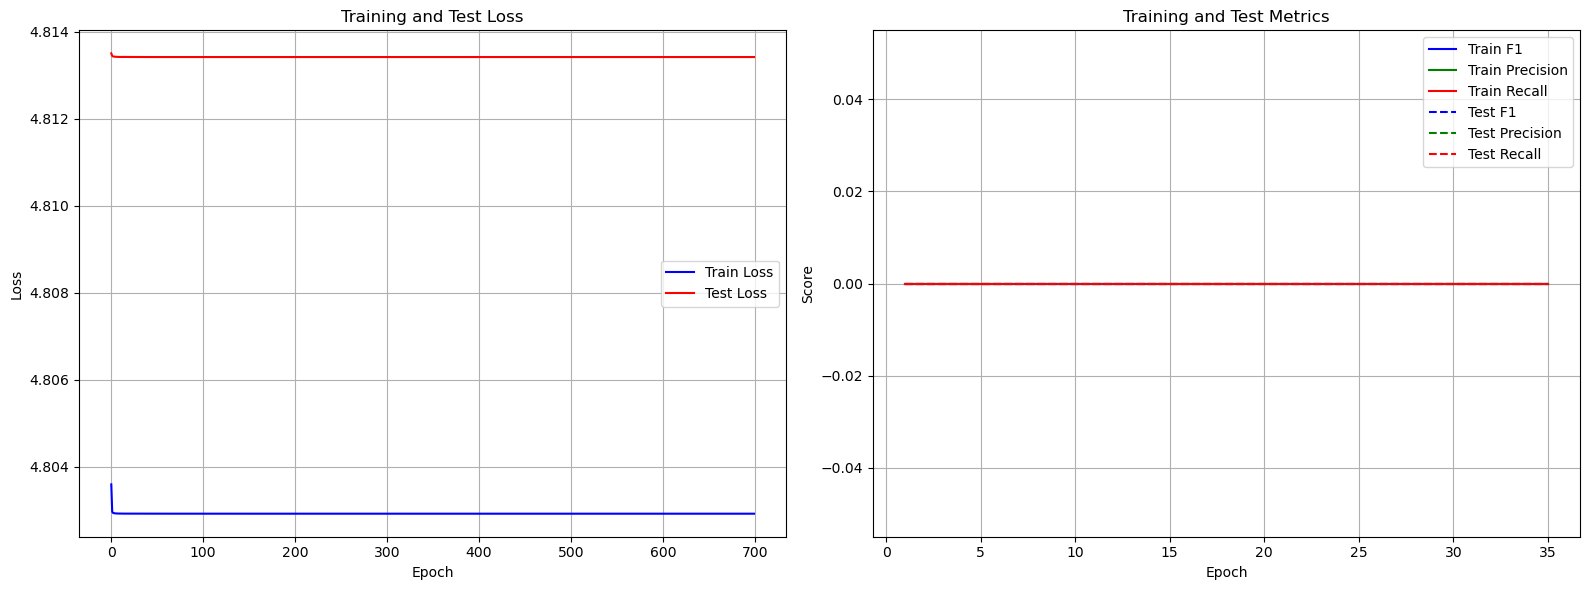

In [7]:
if overwrite or not os.path.exists(model_path):
    for i in range(num_saves): 
        train_losses_tmp, test_losses_tmp = train(model, 
                                                train_dataloader,
                                                test_dataloader, 
                                                optimizer, 
                                                scheduler,
                                                num_epochs, 
                                                device,
                                                loss_type='similarity')
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        # every num_epochs, evaluate the model
        train_eval_metrics = eval_model(model, y_true_train, ts_df_train, txt_ls, ts_encoder_name, text_encoder_name)
        test_eval_metrics = eval_model(model, y_true_test, ts_df_test, txt_ls, ts_encoder_name, text_encoder_name)
        train_eval_metrics_list.append(train_eval_metrics)
        test_eval_metrics_list.append(test_eval_metrics)
        # save model and losses
        torch.save(model.state_dict(), model_path)
        torch.save({
            'train_losses': train_losses,
            'test_losses': test_losses }, loss_path)
        # save train_eval_metrics_list and test_eval_metrics_list
        torch.save({
            'train_evals': train_eval_metrics_list,
            'test_evals': test_eval_metrics_list }, eval_metrics_path)  
    
else:
    model.load_state_dict(torch.load(model_path))
    train_losses = torch.load(loss_path)['train_losses']
    test_losses = torch.load(loss_path)['test_losses']
    train_eval_metrics_list = torch.load(eval_metrics_path)['train_evals']
    test_eval_metrics_list = torch.load(eval_metrics_path)['test_evals']
    confusion_matrices_train = [eval_metrics['confusion_matrix'] for eval_metrics in train_eval_metrics_list]
    confusion_matrices_test = [eval_metrics['confusion_matrix'] for eval_metrics in test_eval_metrics_list]


    # Calculate metrics for training data
    train_metrics = []
    for cm in confusion_matrices_train:
        metrics = calculate_f1_precision_recall_from_cm(cm)
        train_metrics.append(metrics)

    # Calculate metrics for test data
    test_metrics = []
    for cm in confusion_matrices_test:
        metrics = calculate_f1_precision_recall_from_cm(cm)
        test_metrics.append(metrics)

    # Extract metrics
    epochs = range(1, len(train_metrics) + 1)
    train_f1 = [m['f1'] for m in train_metrics]
    train_precision = [m['precision'] for m in train_metrics]
    train_recall = [m['recall'] for m in train_metrics]
    test_f1 = [m['f1'] for m in test_metrics]
    test_precision = [m['precision'] for m in test_metrics]
    test_recall = [m['recall'] for m in test_metrics]

    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot losses on the left subplot
    ax1.plot(train_losses, 'b-', label='Train Loss')
    ax1.plot(test_losses, 'r-', label='Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Test Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot metrics on the right subplot
    ax2.plot(epochs, train_f1, 'b-', label='Train F1')
    ax2.plot(epochs, train_precision, 'g-', label='Train Precision')
    ax2.plot(epochs, train_recall, 'r-', label='Train Recall')
    ax2.plot(epochs, test_f1, 'b--', label='Test F1')
    ax2.plot(epochs, test_precision, 'g--', label='Test Precision')
    ax2.plot(epochs, test_recall, 'r--', label='Test Recall')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.set_title('Training and Test Metrics')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


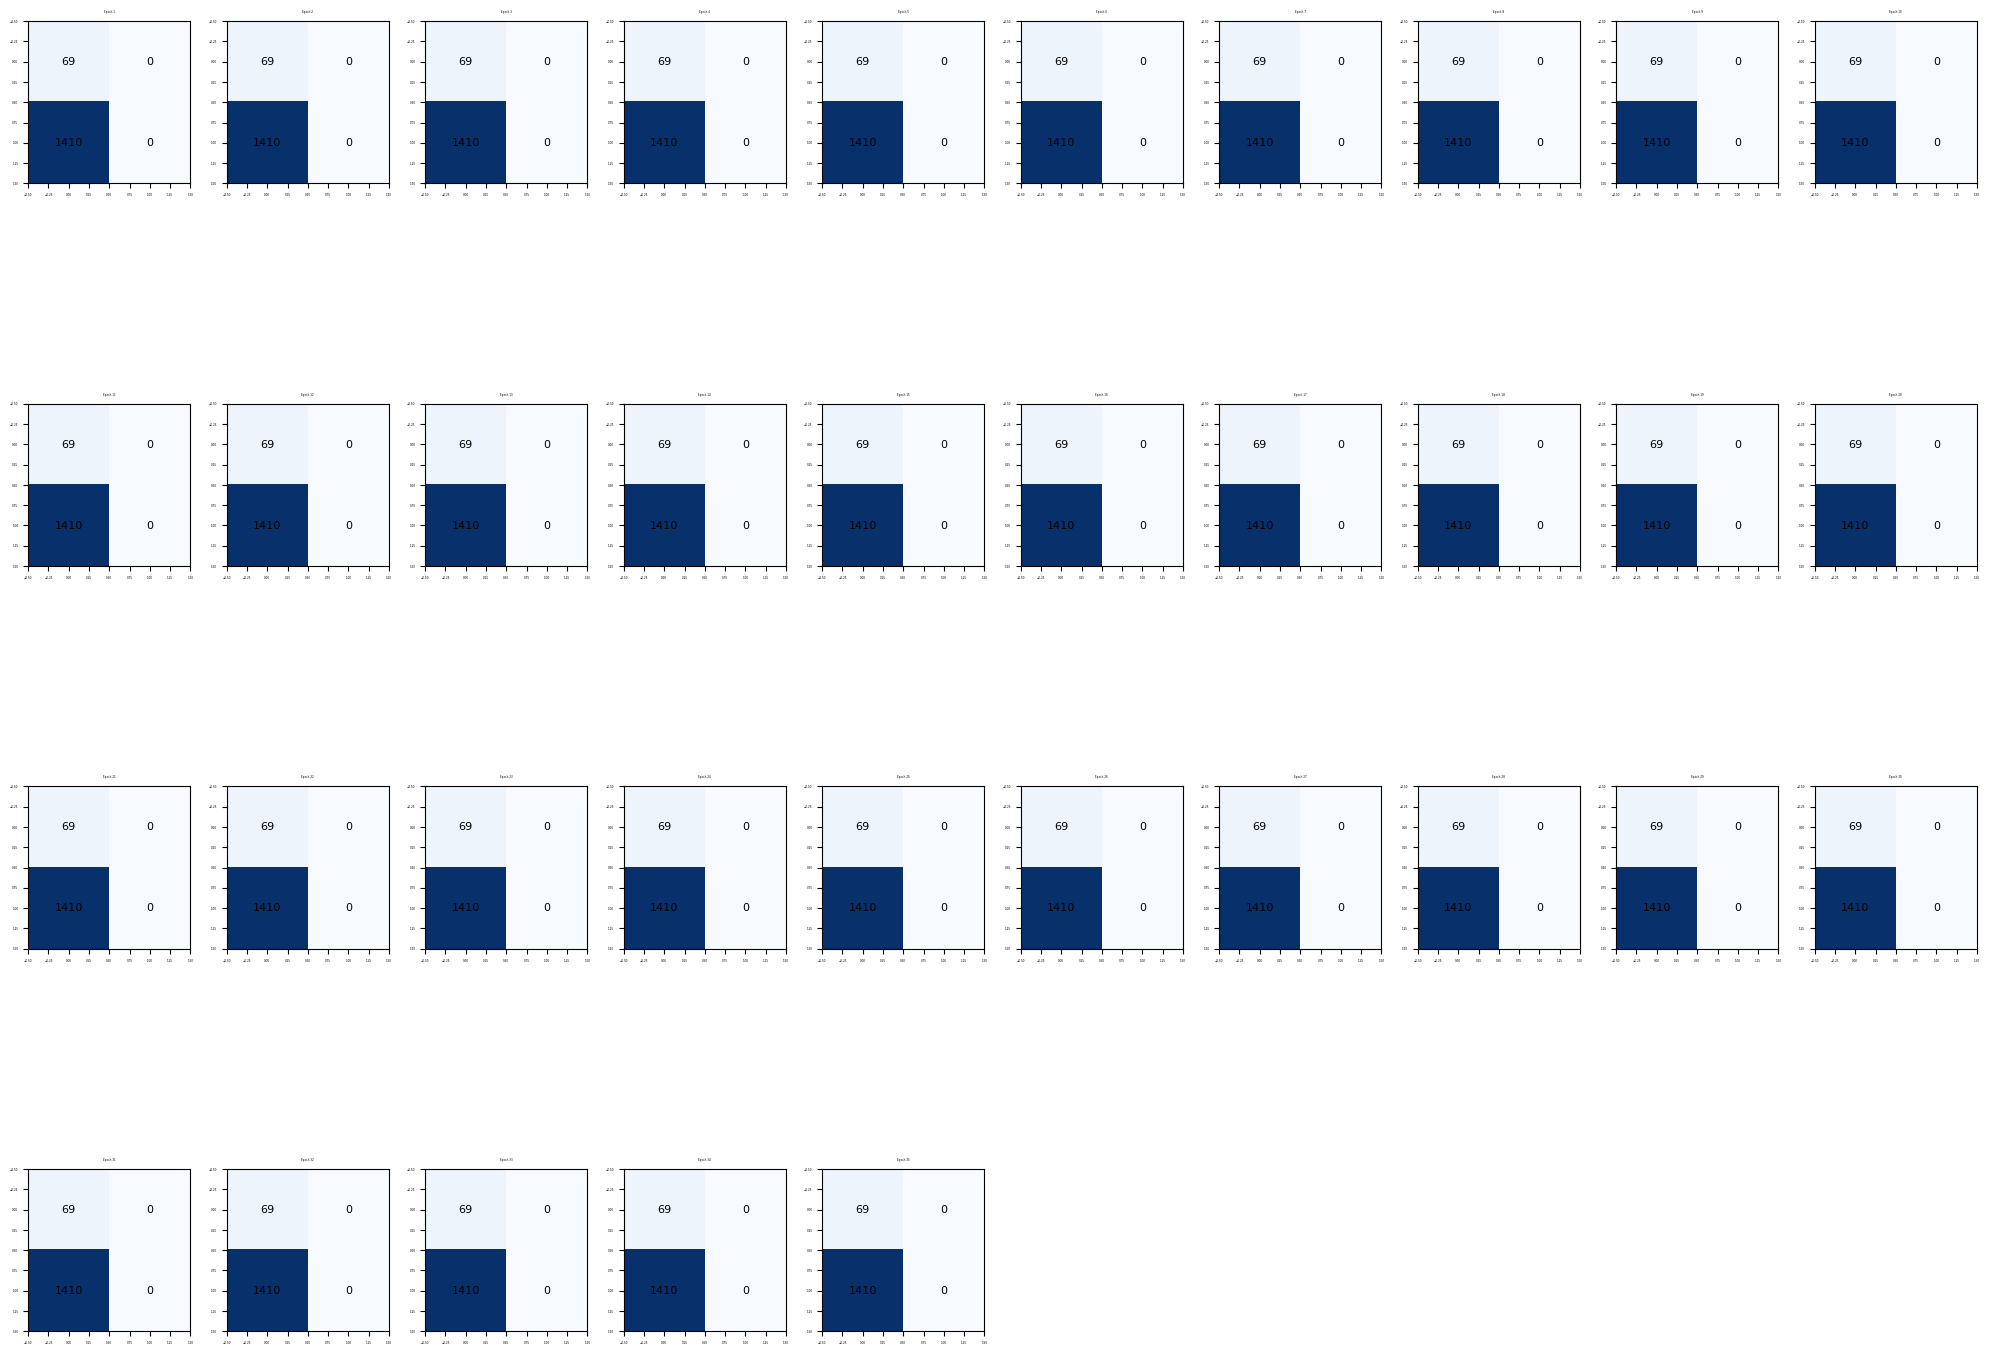

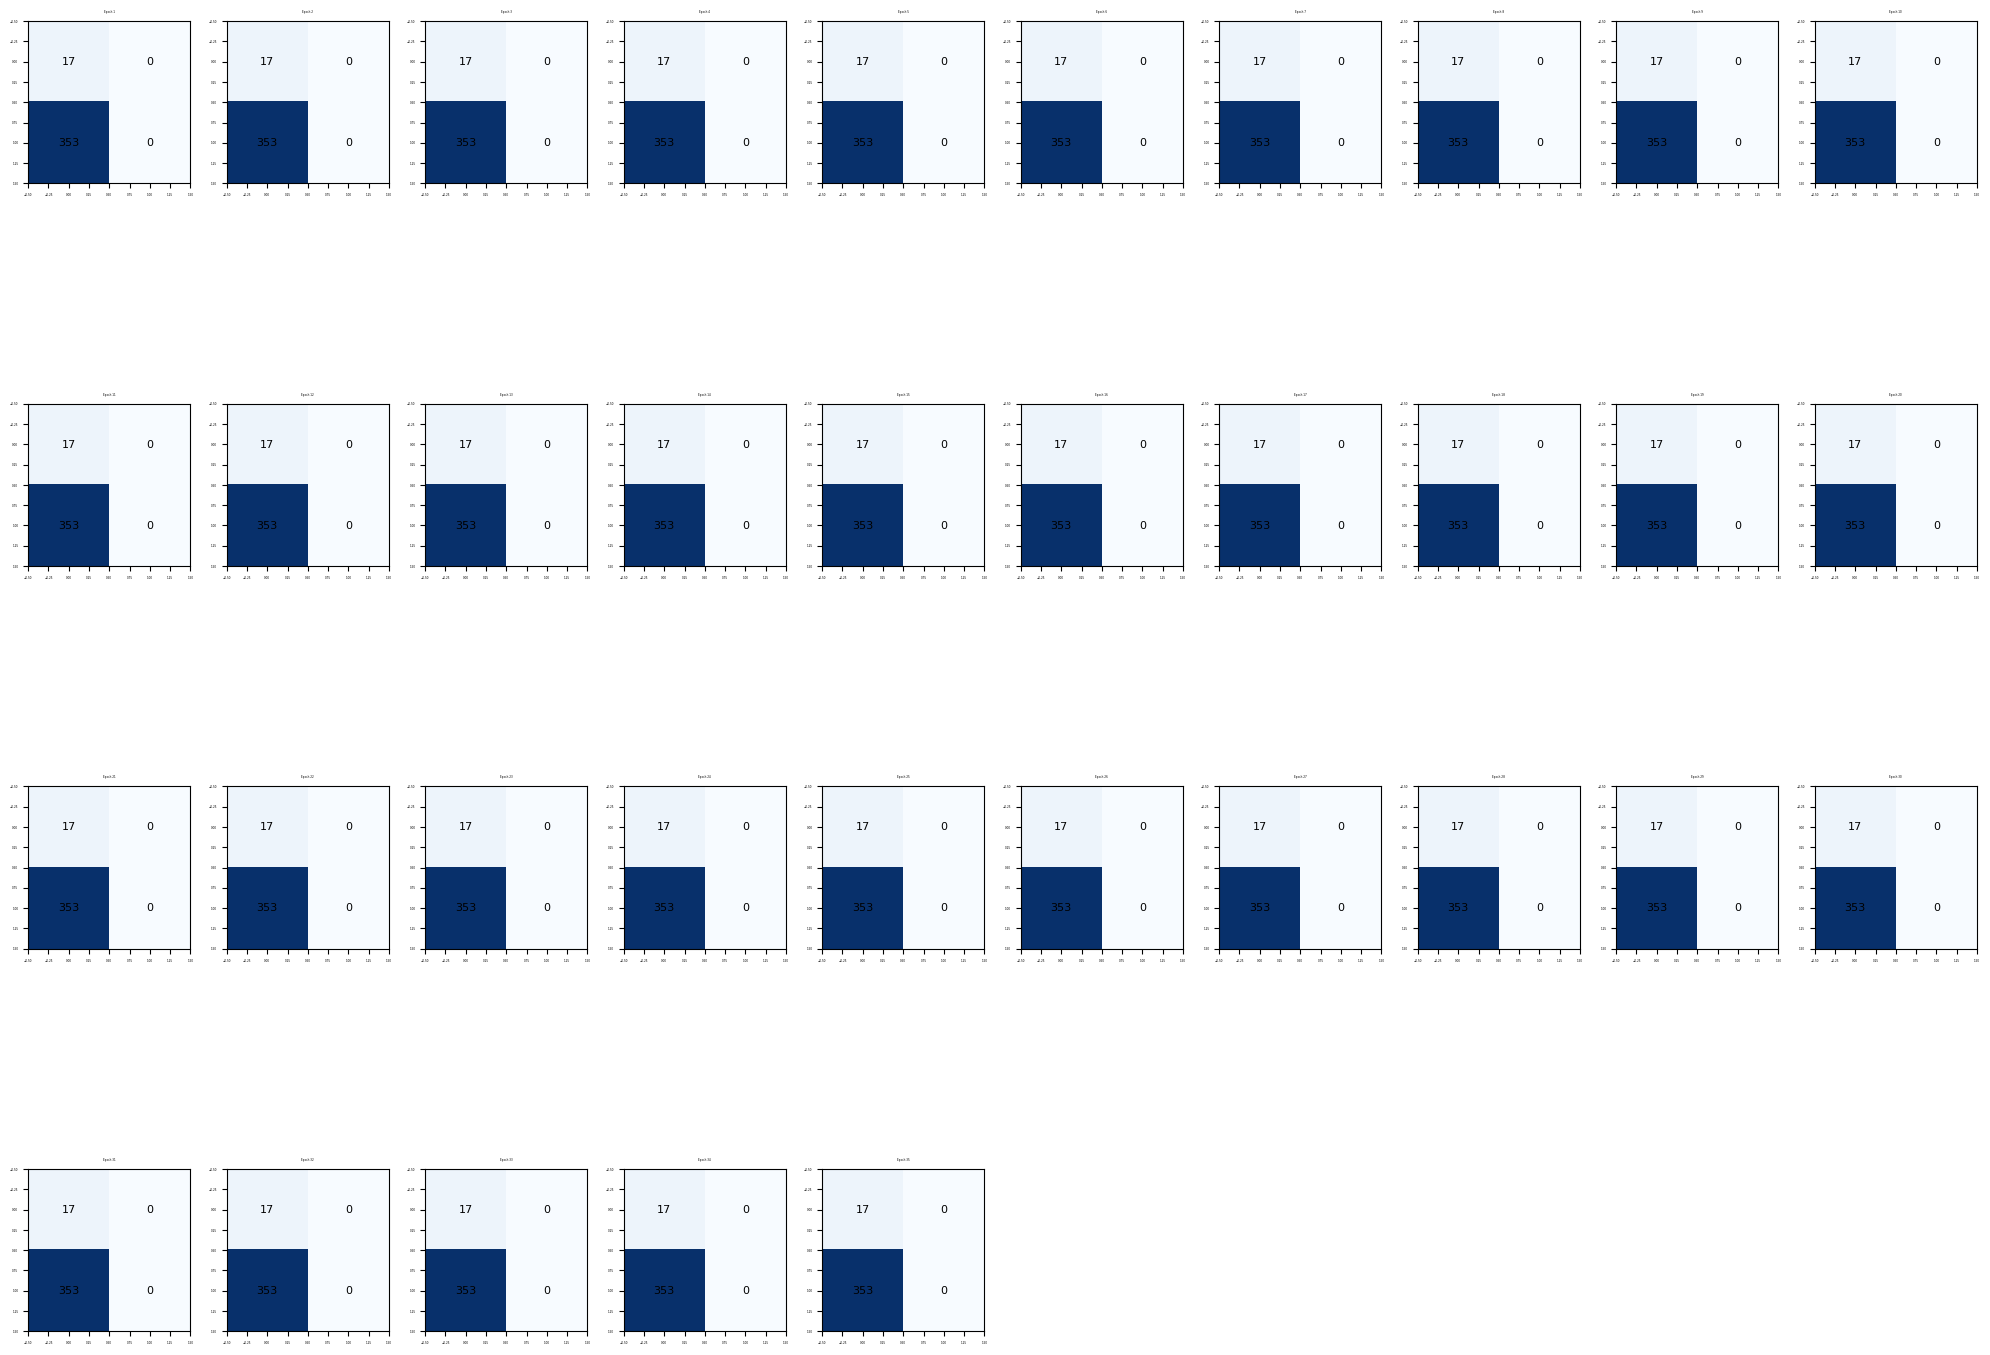

In [8]:


confusion_matrices_train = [eval_metrics['confusion_matrix'] for eval_metrics in train_eval_metrics_list]
confusion_matrices_test = [eval_metrics['confusion_matrix'] for eval_metrics in test_eval_metrics_list]

n_matrices = len(confusion_matrices_train)
n_cols = min(10, n_matrices)  # max 10 columns
n_rows = (n_matrices + n_cols - 1) // n_cols  # ceiling division

plt.figure(figsize=(20, 4*n_rows))
for i, conf_matrix in enumerate(confusion_matrices_train):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(conf_matrix, cmap='Blues')
    plt.title(f'Epoch {i+1}', fontsize=2)
    plt.tick_params(axis='both', which='major', labelsize=2)
    # Add numbers to the cells
    for x in range(conf_matrix.shape[0]):
        for y in range(conf_matrix.shape[1]):
            plt.text(y, x, str(conf_matrix[x, y]),
                    ha='center', va='center', fontsize=8)
plt.tight_layout()
plt.show()


plt.figure(figsize=(20, 4*n_rows))
for i, conf_matrix in enumerate(confusion_matrices_test):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(conf_matrix, cmap='Blues')
    plt.title(f'Epoch {i+1}', fontsize=2)
    plt.tick_params(axis='both', which='major', labelsize=2)
    # Add numbers to the cells
    for x in range(conf_matrix.shape[0]):
        for y in range(conf_matrix.shape[1]):
            plt.text(y, x, str(conf_matrix[x, y]),
                    ha='center', va='center', fontsize=8)
plt.tight_layout()
plt.show()


